In [1]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import log
import  numpy as np
import matplotlib.patches as mpatches

import utils.densities as distributions
from main import parse_arguments
import sample as zodmc
import utils.metrics as metrics
import utils.plots as plots
from samplers.parallel_tempering import parallel_tempering
from samplers.ula import get_ula_samples

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

d = 2
num_modes = 3
s1, s2, s3 = .1, .1, .1 # These are squared
id = torch.eye(d,dtype=torch.float32,device=device).unsqueeze(0)
weights = torch.ones((num_modes),dtype=torch.float32,device=device)/num_modes
means = torch.tensor([[0.,0.],[5.,5.], [-6.,-8.0]],dtype=torch.float32,device=device)
covs = torch.cat([s1 * id, s2 * id, s3 * id],dim=0)
gaussians = [distributions.MultivariateGaussian(means[i],covs[i]) for i in range(num_modes)]
dist = distributions.MixtureDistribution(weights, gaussians)

In [3]:
def rejection_sampler(num_proposals):
    s = max(s1,s2) * 10
    for i in range(num_modes):
        M = max((s/s1)**(d/2), (s/s2)**(d/2) * torch.exp(torch.sum(means[i]**2)/2/(s-s2)).cpu().detach().item())
    prop_dist = distributions.MultivariateGaussian(torch.tensor([0.,0.],dtype=torch.float32,device=device), id[0] * s)
    prop = torch.randn((num_proposals,d),device=device).to(dtype=torch.float32) * s**.5
    rand = torch.rand((num_proposals,1),device=device).to(dtype=torch.float32)
    acc = torch.exp( dist.log_prob(prop) - prop_dist.log_prob(prop) - log(M)) > rand
    acc = acc.expand((-1,2))
    return prop[acc].view(-1,d)

def get_zodmc_config(num_samples):
    config = parse_arguments()
    config.score_method = 'p0t'
    config.p0t_method = 'rejection'
    config.dimension = d
    config.num_batches = 1
    config.sampling_batch_size = num_samples
    config.num_estimator_samples = 5000
    config.sampling_method = 'ei'
    config.T = 2.
    config.sampling_eps = 5e-3
    config.disc_steps = 15
    return config

100%|██████████| 49/49 [00:00<00:00, 184.49it/s]


Oracle complexity 50000000 generated 1
666


Oracle complexity 49950000 generated 666


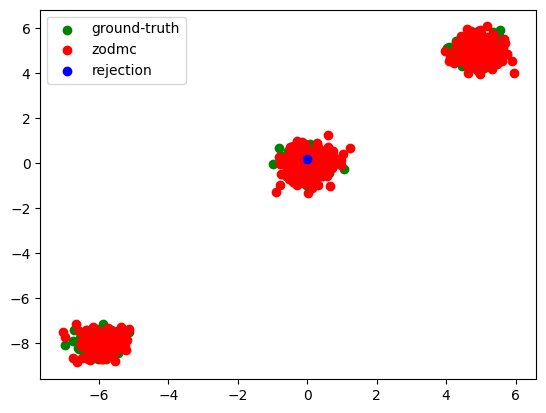

In [4]:
# Rejection
num_proposals = 1000000
num_iters = 50
rej_samples = rejection_sampler(num_proposals)
for i in tqdm(range(num_iters - 1)):
    samples = rejection_sampler(num_proposals)
    rej_samples = torch.cat((rej_samples,samples),dim=0)
oracle_complexity_rej = num_proposals * num_iters
print(f'Oracle complexity {oracle_complexity_rej} generated {rej_samples.shape[0]}')

# ZODMC
num_rej_samples = rej_samples.shape[0]
config = get_zodmc_config(num_rej_samples)
num_zodmc_samples = oracle_complexity_rej//(config.disc_steps * config.num_estimator_samples)
config.sampling_batch_size = num_zodmc_samples
print(config.sampling_batch_size)
zodmc_samples= zodmc.sample(config,distribution=dist)
oracle_complexity_zodmc = config.num_estimator_samples * config.disc_steps * config.sampling_batch_size
print(f'Oracle complexity {oracle_complexity_zodmc} generated {config.sampling_batch_size}')


ground_truth_samples = dist.sample(num_zodmc_samples)
plt.scatter(ground_truth_samples[:,0].cpu().detach().numpy(),
            ground_truth_samples[:,1].cpu().detach().numpy(),color='green')
plt.scatter(zodmc_samples[:,0].cpu().detach().numpy(),
            zodmc_samples[:,1].cpu().detach().numpy(),color='red')
plt.scatter(rej_samples[:,0].cpu().detach().numpy(),
            rej_samples[:,1].cpu().detach().numpy(),color='blue')
plt.legend(['ground-truth','zodmc','rejection'])
plt.show()



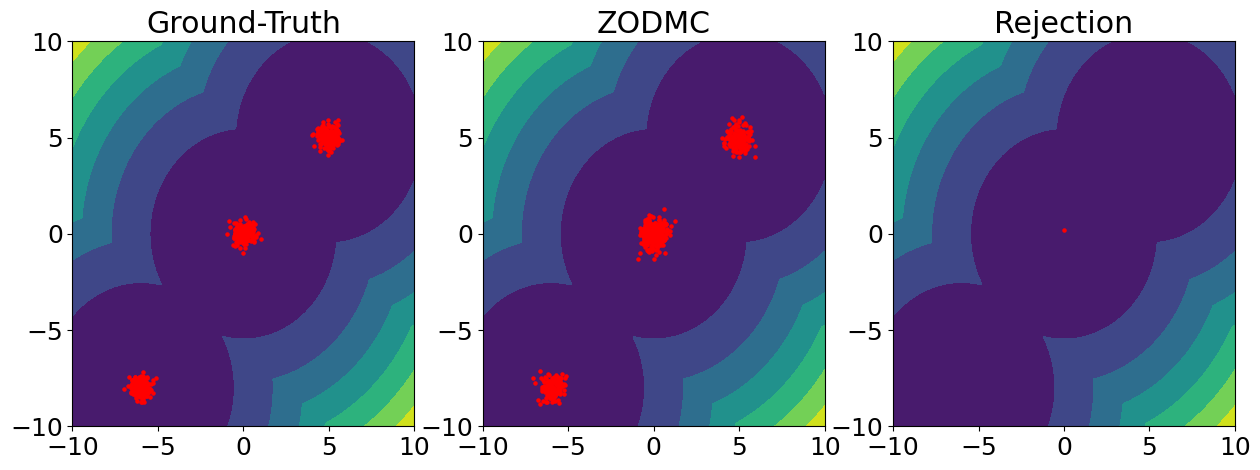

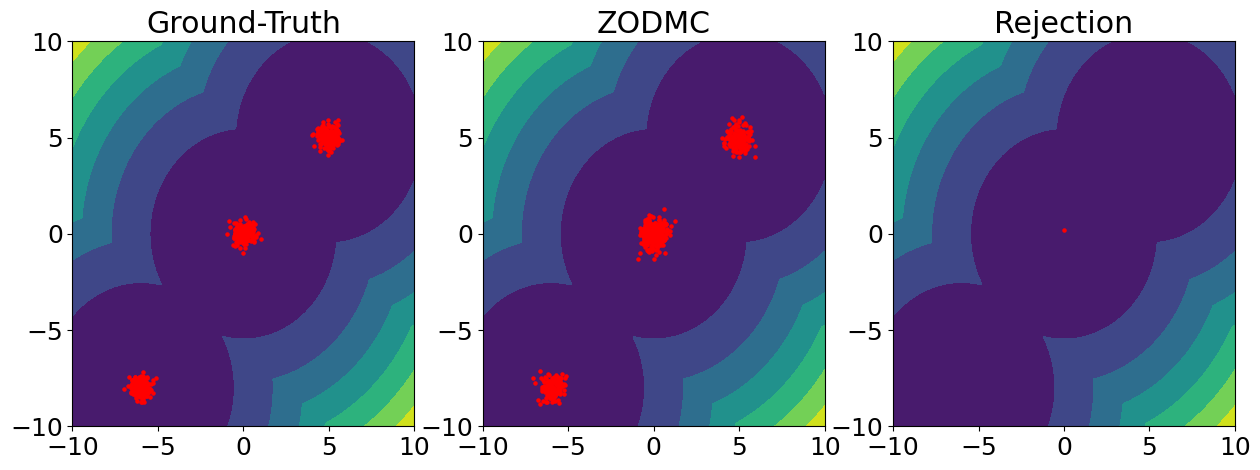

In [5]:
plots.plot_all_samples(
    [ground_truth_samples,zodmc_samples, rej_samples],
    ['Ground-Truth','ZODMC','Rejection'],
    [-10,10], [-10,10],
    dist.log_prob
)
# print(f'Oracle complexity zodmc     {oracle_complexity_zodmc : 10} with W2 {metrics.get_w2(ground_truth_samples, zodmc_samples) : 4}')
# print(f'Oracle complexity rejection {oracle_complexity_rej : 10} with W2 {metrics.get_w2(ground_truth_samples, rej_samples) : 4}')
# print(f'Oracle complexity parallel  {oracle_complexity_parallel : 10} with W2 {metrics.get_w2(ground_truth_samples, parallel_temp_samples) : 4}')
